# OxfordFlower102 MobileNet


In [1]:
!pip install timm

In [2]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set Dataset amd Dataloader

In [4]:
import json
with open('/kaggle/input/pytorch-challange-flower-dataset/cat_to_name.json', 'r') as f:
    cat2name_mapping = json.load(f)
#print(cat2name_mapping)
class_names = [cat2name_mapping[cat] for cat in cat2name_mapping]
cat_list = [cat for cat in cat2name_mapping]
#print(cat_list)
print(class_names)
N=list(range(len(class_names)))
cat2N_mapping=dict(zip(cat_list,N)) 
name2N_mapping=dict(zip(class_names,N)) 
N2name_mapping=dict(zip(N,class_names))  

['fire lily', 'canterbury bells', 'bolero deep blue', 'pink primrose', 'mexican aster', 'prince of wales feathers', 'moon orchid', 'globe-flower', 'grape hyacinth', 'corn poppy', 'toad lily', 'siam tulip', 'red ginger', 'spring crocus', 'alpine sea holly', 'garden phlox', 'globe thistle', 'tiger lily', 'ball moss', 'love in the mist', 'monkshood', 'blackberry lily', 'spear thistle', 'balloon flower', 'blanket flower', 'king protea', 'oxeye daisy', 'yellow iris', 'cautleya spicata', 'carnation', 'silverbush', 'bearded iris', 'black-eyed susan', 'windflower', 'japanese anemone', 'giant white arum lily', 'great masterwort', 'sweet pea', 'tree mallow', 'trumpet creeper', 'daffodil', 'pincushion flower', 'hard-leaved pocket orchid', 'sunflower', 'osteospermum', 'tree poppy', 'desert-rose', 'bromelia', 'magnolia', 'english marigold', 'bee balm', 'stemless gentian', 'mallow', 'gaura', 'lenten rose', 'marigold', 'orange dahlia', 'buttercup', 'pelargonium', 'ruby-lipped cattleya', 'hippeastrum'

In [5]:
path_label=[]
for dirname, _, filenames in os.walk('/kaggle/input/pytorch-challange-flower-dataset/dataset/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg' and dirname.split('/')[-1] in cat_list:
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            path_label+=[(path,cat2N_mapping[label])]
            
tpath_label=[]
for dirname, _, filenames in os.walk('/kaggle/input/pytorch-challange-flower-dataset/dataset/valid'):
    for filename in filenames:
        if filename[-4:]=='.jpg' and dirname.split('/')[-1] in cat_list:
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            tpath_label+=[(path,cat2N_mapping[label])]            

In [6]:
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [7]:
train_data = ImageDataset(path_label, transform)
test_data = ImageDataset(tpath_label, transform)

In [8]:
labels = [label for _, label in train_data.path_label]

In [9]:
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data,batch_size=32)

In [10]:
for images, labels in train_loader:
    break
im=make_grid(images,nrow=16)

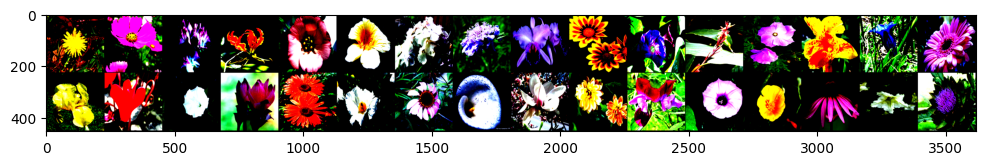

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [12]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

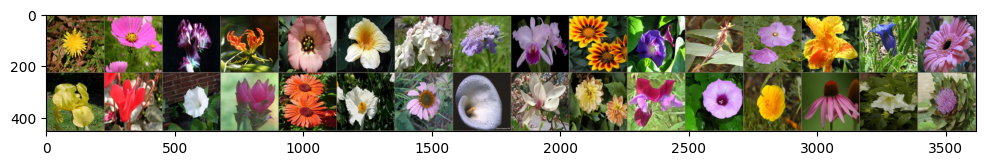

In [13]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Model
mobilenetv2_050

In [14]:
torch.manual_seed(42)

In [15]:
class MyModel(nn.Module):

    def __init__(self, model_name='mobilenetv2_050', pretrained=True):
        super(MyModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained, in_chans=3)
        self.fc1 = nn.Linear(1000,16)
        self.fc2 = nn.Linear(16,64)        
        self.fc3 = nn.Linear(64,len(class_names))
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
model = MyModel() 
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv2_050-3d30d450.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv2_050-3d30d450.pth


In [17]:
epochs=10

import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1        
        y_pred=model(X_train)
        loss=criterion(y_pred,y_train)
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1     
            y_val=model(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)
                  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')        

epoch:  0  batch:  200 [  2000/8000]  loss: 3.94558883  accuracy:  22.700%
epoch:  1  batch:  200 [  2000/8000]  loss: 1.75835919  accuracy:  99.600%
epoch:  2  batch:  200 [  2000/8000]  loss: 1.28981555  accuracy: 185.550%
epoch:  3  batch:  200 [  2000/8000]  loss: 0.84171706  accuracy: 227.600%
epoch:  4  batch:  200 [  2000/8000]  loss: 0.62413710  accuracy: 253.100%
epoch:  5  batch:  200 [  2000/8000]  loss: 0.50008702  accuracy: 268.800%
epoch:  6  batch:  200 [  2000/8000]  loss: 0.35572380  accuracy: 283.400%
epoch:  7  batch:  200 [  2000/8000]  loss: 0.25559321  accuracy: 291.400%
epoch:  8  batch:  200 [  2000/8000]  loss: 0.08892517  accuracy: 297.100%
epoch:  9  batch:  200 [  2000/8000]  loss: 0.13471833  accuracy: 299.350%

Duration: 3698 seconds


# Predict

In [18]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
            
print(y_true[0:5])            
print(y_pred[0:5])

[6, 55, 55, 55, 68]
[87, 55, 55, 55, 68]


In [19]:
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                           precision    recall  f1-score   support

                fire lily     1.0000    1.0000    1.0000         4
         canterbury bells     0.3333    1.0000    0.5000         2
         bolero deep blue     0.6000    0.7500    0.6667         4
            pink primrose     1.0000    1.0000    1.0000         8
            mexican aster     1.0000    1.0000    1.0000         7
 prince of wales feathers     1.0000    1.0000    1.0000         1
              moon orchid     0.0000    0.0000    0.0000         1
             globe-flower     0.6667    1.0000    0.8000         2
           grape hyacinth     0.6667    1.0000    0.8000         2
               corn poppy     1.0000    0.6667    0.8000         3
                toad lily     1.0000    1.0000    1.0000         4
               siam tulip     1.0000    0.3333    0.5000         3
               red ginger     1.0000    0.8000    0.8889         5
            spring crocus     1.0000    1.0000    1.0000     